### Systematic study

In [2]:
# AutoML
import sys
main_path = '../'
sys.path.append(main_path + 'code/auto_ml')
sys.path.append(main_path + 'code/processing')
sys.path.append(main_path + 'code/functions')
sys.path.append(main_path + 'code/models')
sys.path.append(main_path + 'data')

%matplotlib inline
%reload_ext autoreload
%autoreload 2

from auto_ml import AutoML
from comparator import Comparator

# Sklearn
# Classes has been replaced by continuous variables ?
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

import matplotlib.pyplot as plt

In [6]:
input_dir = '../data/systematic_study_data/'

#datasets = ['iris', 'mushrooms', 'boston', 'adult'] #, mimic
datasets = ['mushrooms']
#labels = ['Species', 'class', 'target', 'income'] #, 'DIED'
labels = ['class']
generators = ['mg', 'kd', 'rf', 'wgan']

# !!! WGAN: ONLY 5 FEATURES

In [7]:
def regression_score(X_train, y_train, X_test, y_test, scoring='mse'):
    
    model = RandomForestRegressor(n_estimators=50)
    model.fit(X_train, y_train)
    
    if scoring == 'mse':
        return mean_squared_error(y_test, model.predict(X_test)) # MSE
    
    elif scoring == 'r2':
        return model.score(X_test, y_test) # r2
    
    else:
        raise OSError('{} scoring is not taken in charge'.format(scoring))

mushrooms
mg

2 datasets detected: ready for comparison.
Explained variance ratio of the 23 components: 
 [0.17226234 0.14867563 0.11794562 0.08547242 0.06767446 0.04668063
 0.0442161  0.03766533 0.03321786 0.02748348 0.02639698 0.02521543
 0.0216251  0.01985961 0.01915453 0.01781406 0.01706126 0.01678654
 0.0148258  0.01280586 0.0104815  0.00904049 0.00763897]
Explained variance ratio of the 23 components: 
 [0.17605564 0.15019925 0.12072001 0.08193291 0.06385301 0.04761857
 0.04448418 0.03730223 0.0321521  0.02860028 0.02591446 0.02510236
 0.02105586 0.02051457 0.01835468 0.01810988 0.01681616 0.01612618
 0.01545383 0.01240773 0.01082672 0.00910361 0.00729578]


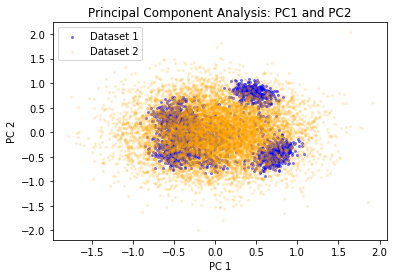

Nearest neighbors metric


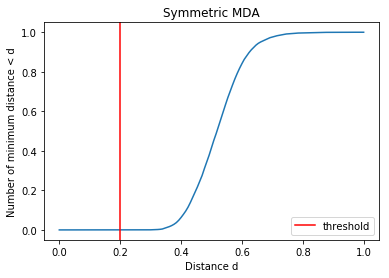

** Privacy: **1.0

** Resemblance: **0.5990208600062261

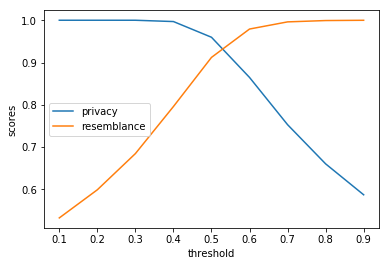

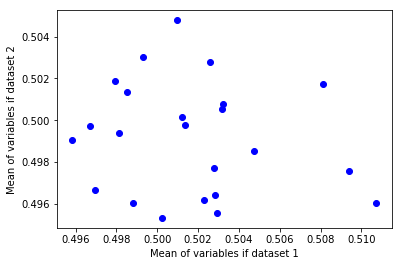

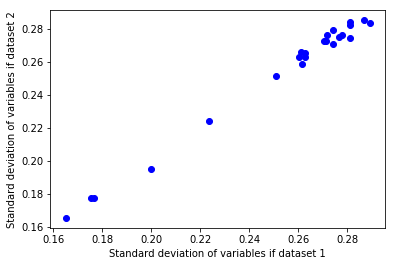

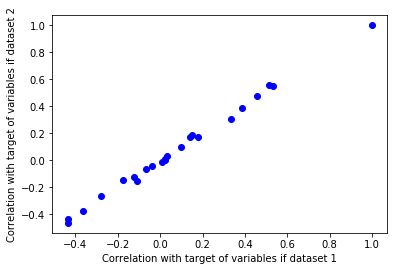

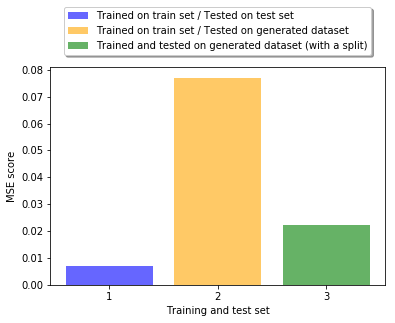

mushrooms
kd

2 datasets detected: ready for comparison.
Explained variance ratio of the 23 components: 
 [0.17226234 0.14867563 0.11794562 0.08547242 0.06767446 0.04668063
 0.0442161  0.03766533 0.03321786 0.02748348 0.02639698 0.02521543
 0.0216251  0.01985961 0.01915453 0.01781406 0.01706126 0.01678654
 0.0148258  0.01280586 0.0104815  0.00904049 0.00763897]
Explained variance ratio of the 23 components: 
 [0.05198345 0.05066644 0.04956166 0.04729126 0.04677702 0.04555991
 0.04426394 0.04414565 0.04337851 0.0432132  0.04297071 0.04264435
 0.04235563 0.04204648 0.04181164 0.04116757 0.0410356  0.04077323
 0.0405113  0.04014765 0.03971088 0.03930375 0.03868017]


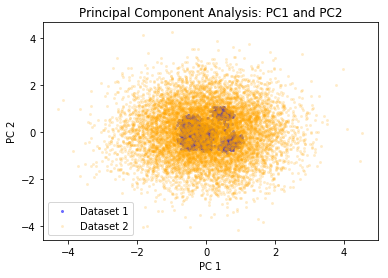

Nearest neighbors metric


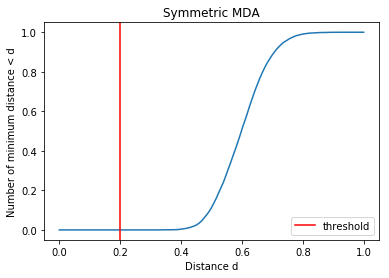

** Privacy: **1.0

** Resemblance: **0.50035379370227

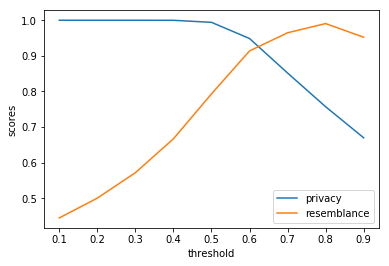

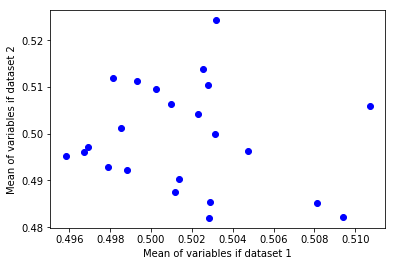

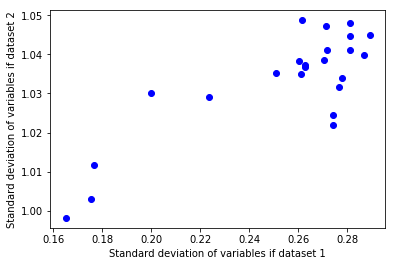

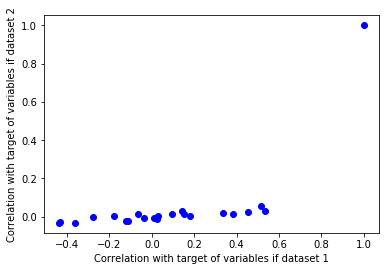

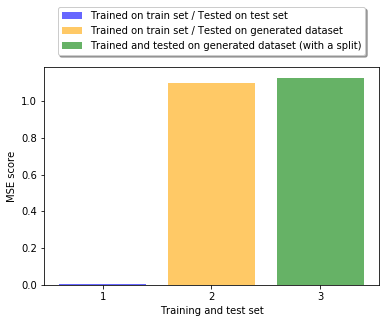

mushrooms
rf

2 datasets detected: ready for comparison.
Explained variance ratio of the 23 components: 
 [0.17226234 0.14867563 0.11794562 0.08547242 0.06767446 0.04668063
 0.0442161  0.03766533 0.03321786 0.02748348 0.02639698 0.02521543
 0.0216251  0.01985961 0.01915453 0.01781406 0.01706126 0.01678654
 0.0148258  0.01280586 0.0104815  0.00904049 0.00763897]
Explained variance ratio of the 23 components: 
 [0.21132651 0.18082851 0.13914509 0.09495033 0.06525565 0.04122926
 0.03854738 0.03030312 0.02493136 0.02209163 0.02049508 0.01744714
 0.01626311 0.01374486 0.01212465 0.0114776  0.01111588 0.01019374
 0.00980812 0.00860629 0.00788398 0.00666846 0.00556225]


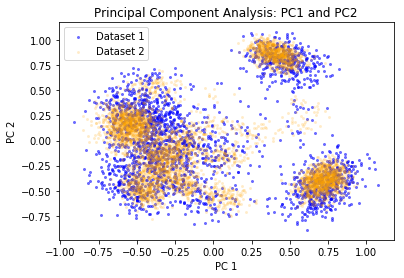

Nearest neighbors metric


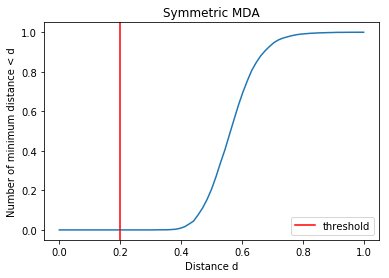

** Privacy: **1.0

** Resemblance: **0.5411414996874042

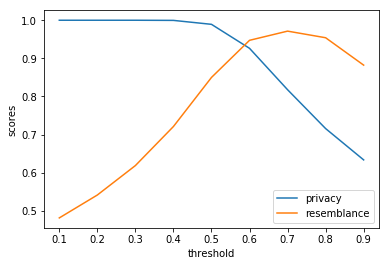

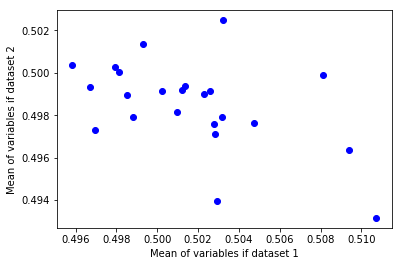

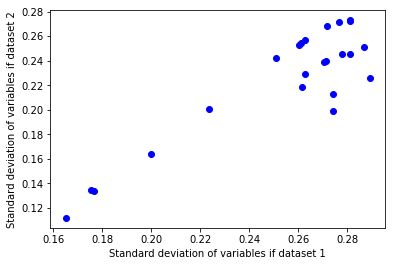

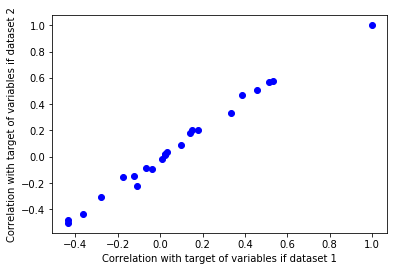

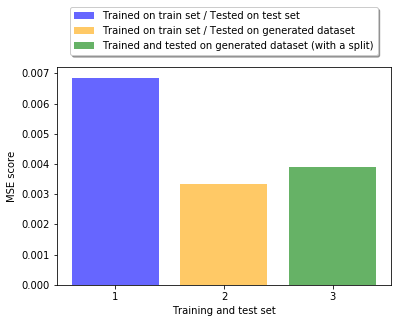

mushrooms
wgan

2 datasets detected: ready for comparison.
Explained variance ratio of the 23 components: 
 [0.17226234 0.14867563 0.11794562 0.08547242 0.06767446 0.04668063
 0.0442161  0.03766533 0.03321786 0.02748348 0.02639698 0.02521543
 0.0216251  0.01985961 0.01915453 0.01781406 0.01706126 0.01678654
 0.0148258  0.01280586 0.0104815  0.00904049 0.00763897]
Explained variance ratio of the 23 components: 
 [0.19163902 0.16821082 0.11992472 0.10097166 0.05760316 0.04433616
 0.04047755 0.03758246 0.02998692 0.02512383 0.02400798 0.02182715
 0.02059824 0.01807211 0.01704696 0.01489518 0.01407186 0.0130757
 0.01121187 0.01068436 0.00831858 0.00681464 0.00351907]


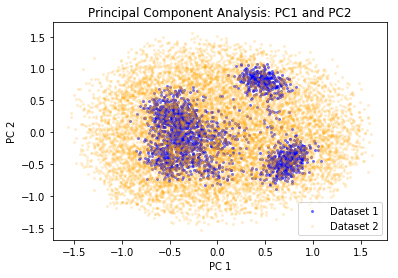

Nearest neighbors metric


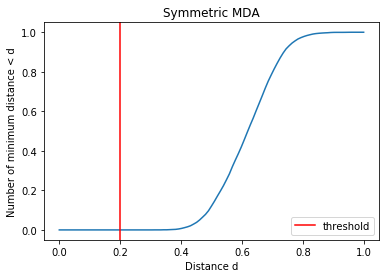

** Privacy: **1.0

** Resemblance: **0.47850189046348673

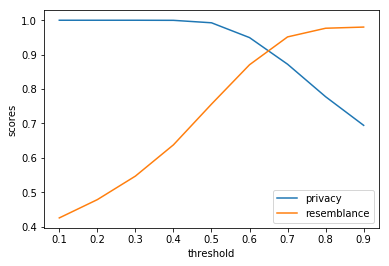

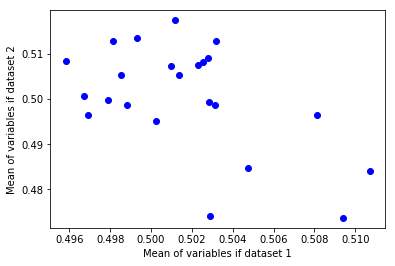

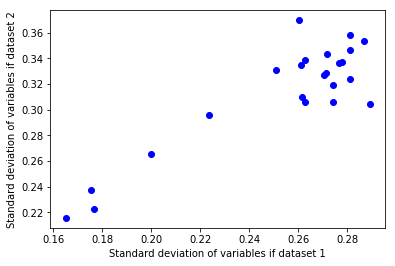

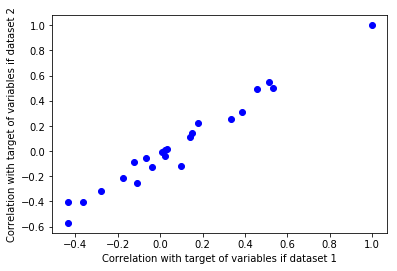

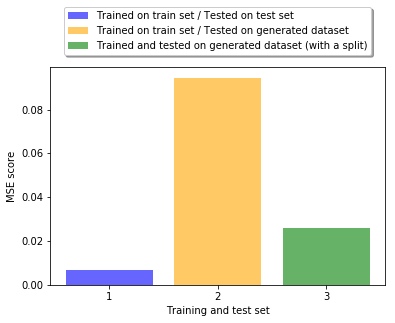

In [8]:
# Loop on datasets
for i, dataset in enumerate(datasets):
    
    # Loop on generative models
    for generator in generators:

        # Intro
        print(dataset)
        print(generator)
        print()
        
        label = labels[i]

        # Train original dataset
        train = AutoML(input_dir + dataset, dataset + '_train_sdv')
        train_data = train.get_data()
        train_y = train_data[label]
        train_X = train_data.drop([label], axis=1)
        
        # Test original dataset
        test = AutoML(input_dir + dataset, dataset + '_test_sdv')
        test_data = test.get_data()
        test_y = test_data[label]
        test_X = test_data.drop([label], axis=1)
        
        # Generated dataset
        gen = AutoML(input_dir + dataset, dataset +'_'+ generator)
        gen_data = gen.get_data()
        gen_y = gen_data[label]
        gen_X = gen_data.drop([label], axis=1)

        # Plots
        comparator = Comparator(test, gen)
        comparator.show_pca()
        # comparator.show_lda() # need classes
        comparator.show_mda()
        comparator.show_mda_threshold()
        comparator.compare_marginals(metric='mean')
        comparator.compare_marginals(metric='std')
        comparator.compare_marginals(metric='corr', target=label)
        
        # Regression scores
        scores = []
        
        # train / test
        scores.append(regression_score(train_X, train_y, test_X, test_y))
        
        # train / gen
        scores.append(regression_score(train_X, train_y, gen_X, gen_y))
        
        # gen / gen
        gen_X_train, gen_X_test, gen_y_train, gen_y_test = train_test_split(gen_X, gen_y, test_size=0.3)
        scores.append(regression_score(gen_X_train, gen_y_train, gen_X_test, gen_y_test))
        
        x = [1, 2, 3]
        
        legends = {1:('Trained on train set / Tested on test set','b'), 
              2:('Trained on train set / Tested on generated dataset','orange'), 
              3:('Trained and tested on generated dataset (with a split)','g')}

        ax1 = plt.subplot(111)

        for j in range(len(x)):
            ax1.bar(x[j], scores[j], width=0.8, bottom=0.0, align='center', color=legends[x[j]][1], alpha=0.6, label=legends[x[j]][0])
        
        ax1.set_xticks(x)
        ax1.set_xticklabels([i for i in x])

        ax1.legend(loc='upper center', bbox_to_anchor=(0.5, 1.3),
                  ncol=1, fancybox=True, shadow=True)

        plt.xlabel('Training and test set')
        plt.ylabel('MSE score')
        
        plt.show()